In [483]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image, ImageFilter

### A. Classic Hopfield Network

In [484]:
# Build a classic Hopfield Network
class ClassicHopfieldNet:
    def __init__(self, X, b=None):
        self.X = X # patterns (N * d)
        self.N, self.d = X.shape[0], X.shape[1]
        self.b = b if b else np.zeros(self.d) # biases
        self.W = np.dot(X.T,X)/self.d # weight matrix (N * N), normalised.
        self.s = None # State
    
    def energy(self):
        """
        Compute the traditional energy function
        """
        return -1/2 * np.dot(self.s,np.dot(self.W,self.s)) + np.dot(self.s,self.b)
    
    def update(self, idx, energy_log):
        for i in idx:
            self.s[i] = np.sign(np.dot(self.W[i,:],self.s) - self.b[i])
    
    def simulate(self, s0, s_targ):
        self.s = s0.copy() # set initial state
        s_old = None
        E = self.energy()
        energy_log = []

        # update until a fixed point is reached
        while not np.array_equal(self.s, s_old):
            # Update state asychronously
            idx = np.random.permutation(self.d)
            s_old = self.s.copy()
            self.update(idx, energy_log)
            
            # log and update energy
            energy_log.append(E)
            E = self.energy()
        
        m = np.dot(self.s, s_targ)/self.d
        return {"state" : self.s,
                "energy" : energy_log,
                "overlap" : m} 

In [485]:
# Load Simpsons images and convert to black and white
for i in range(1,1000,1):
    file_in = 'data/simpsons/{}.png'.format(i)
    file_out = 'data/simpsonsBW/{}.png'.format(i)
    # Separate RGB arrays
    im = Image.open(file_in)
    R, G, B = im.convert('RGB').split()
    r = R.load()
    g = G.load()
    b = B.load()
    w, h = im.size

    t = 80
    # Convert non-black pixels to white
    for i in range(w):
        for j in range(h):
            if(r[i, j] > t or g[i, j] > t  or b[i, j] > t):
                r[i, j] = 255 # Just change R channel

    # Merge just the R channel as all channels
    im = Image.merge('RGB', (R, R, R))
    im.filter(ImageFilter.MinFilter(size=3)).resize((60,60)).save(file_out)

In [486]:
def load_simpson(n): 
    img = Image.open('data/simpsonsBW/{}.png'.format(n)).convert('1')
    img = np.asarray(img.getdata())
    return -1*(img - 255) 

def load_simpson_grey(n): 
    im = Image.open('data/simpsons/{}.png'.format(n)).convert('LA').resize((60,60))
    return 255 - np.asarray(im.getdata())[:,0]

def plot_img(img):
    plt.imshow(img.reshape((60,60)), cmap="Greys")
    #plt.show()
    
def scale_img(img):
    img[np.where(img==img.max())] = 1
    img[np.where(img==img.min())] = -1
    return img

def reverse_scale_img(img):
    img[np.where(img==img.max())] = 255
    img[np.where(img==img.min())] = 0
    return img

def save_img(img, fname):
    plt.imsave(fname, img.reshape((60,60)), cmap="Greys", dpi=300)

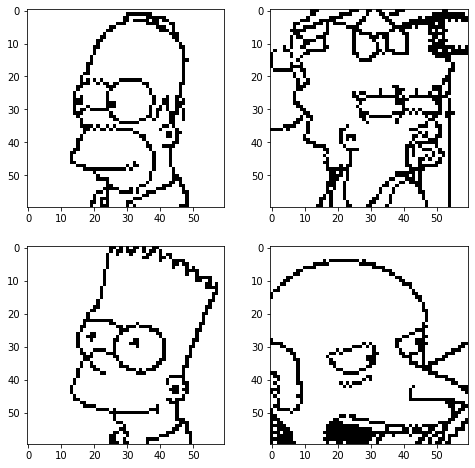

In [487]:
# Select patterns to memorise
patterns = np.array([load_simpson(n) for n in [13,20,152, 201]])

# Plot patterns
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plot_img(patterns[i-1])
plt.show()

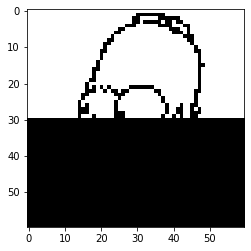

In [488]:
# create a masked homer to use as the starting state
homer = load_simpson(13)
homer_mask = homer.copy()
homer_mask[int(len(homer)/2):] = 255
plot_img(homer_mask)

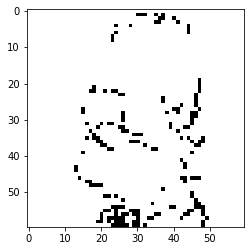

In [489]:
# adjust pixel values for network
X = scale_img(patterns.copy())
homer = scale_img(homer.copy())
homer_mask = scale_img(homer_mask.copy())

# Initialise Hopfield Net 
hop_net = ClassicHopfieldNet(X) 
out = hop_net.simulate(s0=homer_mask, s_targ=homer)

# Plot the retrieved state/pattern
X_out = out['state']
X_out = reverse_scale_img(X_out.copy())
save_img(X_out, "model_out.png")
plot_img(X_out)

In [490]:
# Plot network energy
# fig, ax = plt.subplots(figsize=(6,4))
# ax.plot(out["energy"])
# ax.set_xlabel("Node Updates")
# ax.set_ylabel("Energy")
# plt.savefig("Hopfield_energy.png")

In [491]:
def Hopfield_Storage_Capacity_Sim(N, d, ρ, m, runs, kind="classic"):
    """
    N: number of patterns to store
    d: number of neurons
    ρ: number of initial neurons flipped (initial error)
    m: percentage overlap to be considered succesful
    runs: number of iterations
    """
    suc = 0
    for r in range(runs):
        # matrix of random patterns {-1,1}^d
        M = 2*(np.random.randint(2, size=(N,d)))-1 
        
        # Ensure all patterns are distinct
        for i in range(N-1):
            for j in range(i, N):
                if ((np.dot(M[i,:], M[j,:]) == d) and (i!=j)):
                    M[j,:] = 2*(np.random.randint(2, size=(1,d)))-1
                    i=0
        
        # Instantiate Hopfield Net (biases == 0)
        if (kind == "classic"):
            hop_net = ClassicHopfieldNet(M)
        else:
            hop_net = ModernHopfieldNet(M, F=np.exp, λ=1)

        # Create a starting state which is ρd% random
        a = int(ρ*d)
        S = M[0,:].copy()
        diff = np.random.permutation(d)[0:a]
        S[diff] = -1*S[diff]
        
        # Simulate
        out = hop_net.simulate(S, M[0,:])
        
        # 'Convergence' if the final state overlaps
        # with the target sufficiently (100*m%)
        if out["overlap"] >= m:
            suc += 1
            
    return (suc/runs) 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


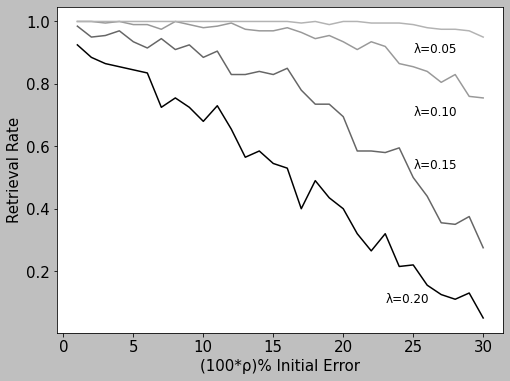

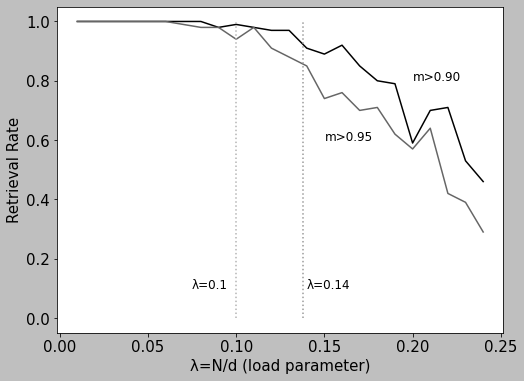

In [492]:
#Run simulations
# A. retrival rate vs α
ret_rate_1 = [[Hopfield_Storage_Capacity_Sim(N=N_i, d=100, ρ=0.15, m=0.90, runs=100) for N_i in range(1,25,1)] ,
              [Hopfield_Storage_Capacity_Sim(N=N_i, d=100, ρ=0.15, m=0.95, runs=100) for N_i in range(1,25,1)]]

# B. retrival rate vs initial error
init_error = np.arange(1,31)
alphas = [0.20,0.15,0.10,0.05]
ret_rate_2 = [[],[],[],[]]
for i, alpha in enumerate(alphas):
    for err in init_error/100:
        d = 100
        N_i = int(alpha*d)
        out = Hopfield_Storage_Capacity_Sim(N=N_i, d=100, ρ=err, m=0.95, runs=200)
        ret_rate_2[i].append(out)


# Plot simulations
plt.style.use('grayscale')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(init_error, ret_rate_2[0])
ax.plot(init_error, ret_rate_2[1])
ax.plot(init_error, ret_rate_2[2])
ax.plot(init_error, ret_rate_2[3])
plt.text(x=23, y=0.1, s="λ=0.20", fontsize=12)
plt.text(x=25, y=0.53, s="λ=0.15", fontsize=12)
plt.text(x=25, y=0.7, s="λ=0.10", fontsize=12)
plt.text(x=25, y=0.9, s="λ=0.05", fontsize=12)
ax.set_xlabel("(100*ρ)% Initial Error")
ax.set_ylabel("Retrieval Rate")
plt.savefig("initial_error_classic.png", cdi=150)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0.01,0.24,24), ret_rate_1[0])
ax.plot(np.linspace(0.01,0.24,24), ret_rate_1[1])
ax.plot([0.138,0.138], [0,1], linestyle=":")
ax.plot([0.1,0.1], [0,1], linestyle=":")
ax.set_xlabel("λ=N/d (load parameter)")
ax.set_ylabel("Retrieval Rate")
plt.text(x=0.20, y=0.8, s="m>0.90", fontsize=12)
plt.text(x=0.15, y=0.6, s="m>0.95", fontsize=12)
plt.text(x=0.14, y=0.1, s="λ=0.14", fontsize=12)
plt.text(x=0.075, y=0.1, s="λ=0.1", fontsize=12)
plt.savefig("load_parameter_classic.png", cdi=150)

### B. Modern Hopfield Networks

In [493]:
# Build a classic Hopfield Network
class ModernHopfieldNet:
    def __init__(self, X, F, λ):
        self.X = X # patterns (N x d)
        self.N = X.shape[0] # number of patterns
        self.d = X.shape[1]
        self.λ = λ
        self.F = F # interaction fn
        self.s = None # State
    
    def energy(self):
        return -1*np.sum([self.F(np.dot(self.s, self.X[k,:])/self.λ) for k in range(self.N)])
    
    def T(self, idx):
        for i in idx:
            s_ptv, s_ngtv = self.s.copy(),self.s.copy()
            s_ptv[i], s_ngtv[i] = 1, -1
            S = np.sum([self.F(np.dot(s_ptv, self.X[k,:])/self.λ) - self.F(np.dot(s_ngtv, self.X[k,:])/self.λ)
                          for k in range(self.N)])
            self.s[i] = np.sign(S)
    
    def simulate(self, s0, s_targ):
        self.s = s0
        s_old = None
        E = self.energy()
        energy_log = []
        
        
        # update until a fixed point is reached
        while not np.array_equal(self.s, s_old):
            # Update state asychronously
            idx = np.random.permutation(self.d)
            s_old = self.s
            self.T(idx)
            
            # log and update energy
            energy_log.append(E)
            E = self.energy()
        
        m = np.dot(self.s, s_targ)/self.d
        return {"state" : self.s,
                "energy" : energy_log,
                "overlap" : m} 

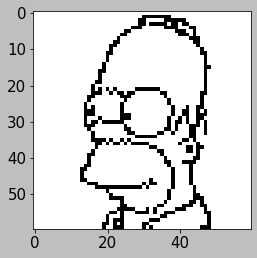

In [494]:
# adjust pixel values for network
X = scale_img(patterns.copy())
homer = scale_img(homer.copy())
homer_mask = scale_img(homer_mask.copy())

# Initialise Hopfield Net 
hop_net = ModernHopfieldNet(X, F=np.exp, λ=10) 
out = hop_net.simulate(s0=homer_mask, s_targ=homer)

# Plot the retrieved state/pattern
X_out = out['state']
X_out = reverse_scale_img(X_out.copy())
save_img(X_out, "model_out.png")
plot_img(X_out)

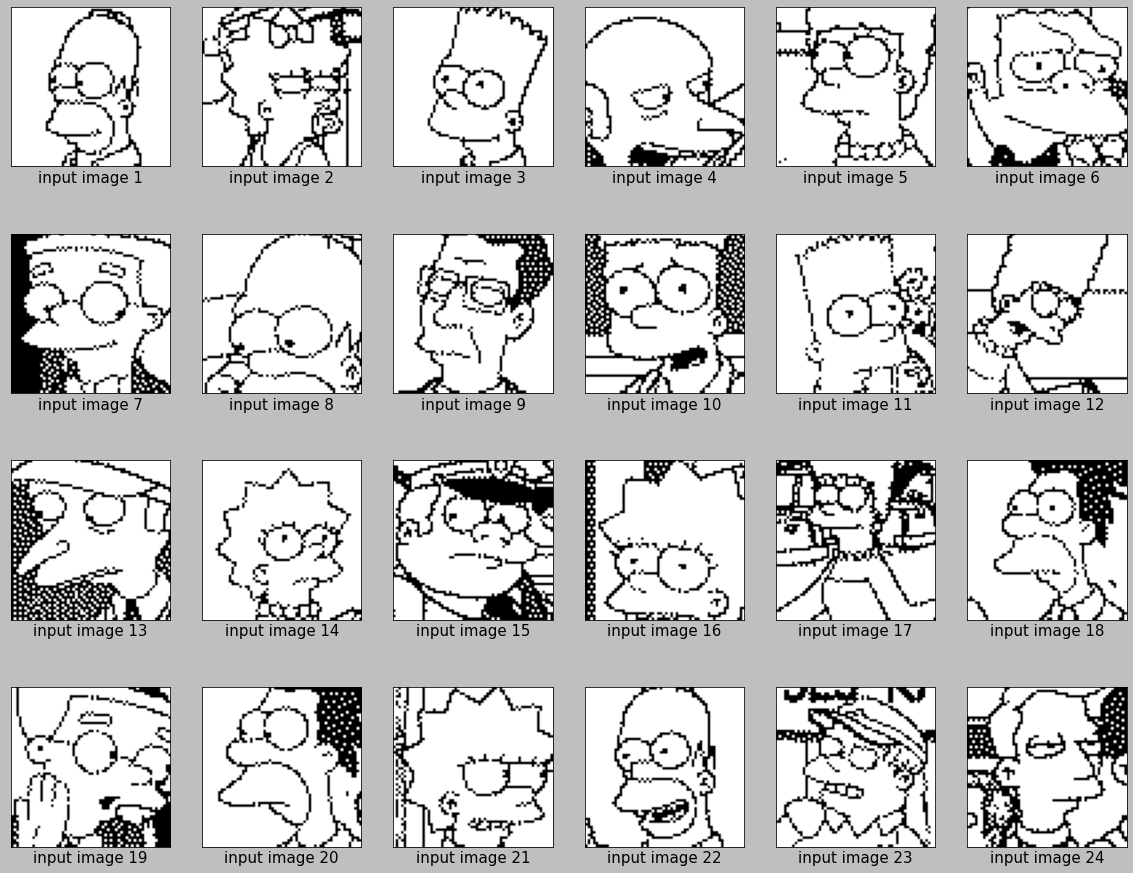

In [495]:
# Select patterns to memorise
patterns = np.array([load_simpson(n) for n in [13, 20, 152, 201, 505, 812, 396, 548, 416, 150, 899, 136, 
                                               494, 445, 639, 459, 952, 973, 918, 977, 108, 979, 607, 532]])

# Plot patterns
fig=plt.figure(figsize=(20, 16))
columns = 6
rows = 4
ax = []
for i in range(1, columns*rows +1):
    ax.append(fig.add_subplot(rows, columns, i))
    plot_img(patterns[i-1])
    ax[i-1].set_xticks([])
    ax[i-1].set_yticks([])
    ax[i-1].set_xlabel("input image {}".format(i))

# fig.subplots_adjust(wspace=0.2)
plt.savefig("24_simpsons.png", dpi=150)
plt.show()

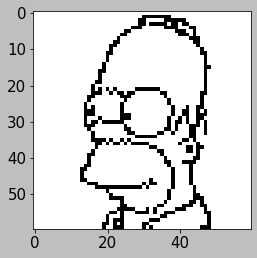

In [496]:
# adjust pixel values for network
X = scale_img(patterns.copy())
homer = scale_img(homer.copy())
homer_mask = scale_img(homer_mask.copy())

# Initialise Hopfield Net 
hop_net = ModernHopfieldNet(X, F=np.exp, λ=10) 
out = hop_net.simulate(s0=homer_mask, s_targ=homer)

# Plot the retrieved state/pattern
X_out = out['state']
X_out = reverse_scale_img(X_out.copy())
save_img(X_out, "model_out.png")
plot_img(X_out)

In [497]:
# Simulate Storage capacity
ρ = 0.15
def I(x): return 0.5*((1+x)*np.log(1+x) + (1-x)*np.log(1-x))
α = I(1-2*ρ)/2
d = 20
N = int(np.exp(α*d)) +1 
Ns = np.arange(1, N*10, 10) # list of pattern numbers 

Ns

array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141])

In [505]:
ret_rate_3 = []
ret_rate_4 = []
for Ni in Ns:
    ret_rate_3.append(Hopfield_Storage_Capacity_Sim(N=Ni, d=d, ρ=ρ, m=0.95, runs=100, kind="modern"))
    ret_rate_4.append(Hopfield_Storage_Capacity_Sim(N=Ni, d=d, ρ=ρ, m=0.9, runs=100, kind="modern"))

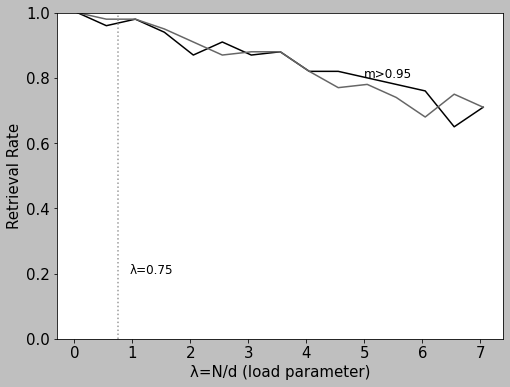

In [506]:
# Plot simulations
plt.style.use('grayscale')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

plt.figure(figsize=(8,6))
plt.xlabel("λ=N/d (load parameter)")
plt.ylabel("Retrieval Rate")
plt.text(x=5, y=0.8, s="m>0.95", fontsize=12)
plt.text(x=N/d+0.2, y=0.2, s="λ=0.75", fontsize=12)
plt.plot(Ns/d, ret_rate_3)
plt.plot(Ns/d, ret_rate_4)
plt.plot([N/d,N/d], [0,1], linestyle=":")
plt.ylim(0.,1.0)
plt.savefig("load_parameter_modern.png", dpi=150)

### 3. Continuous-State Hopfield Network

In [652]:
from scipy.special import softmax
class Hopfield3:
    def __init__(self, X, β):
        self.X = X # d*N
        self.β = β
        self.N = X.shape[1]
        self.M = np.max(np.linalg.norm(X, axis=0))
        self.C = (1/self.β)*(np.log(self.N)) + 0.5*self.M**2
    
    def E(self, ξ):
        v = np.dot(self.X.T, ξ)
#         v = v/np.linalg.norm(v)
        lse = (1/β)*np.log(np.sum(np.exp(self.β*v)))
        return  -lse + 0.5*np.dot(ξ,ξ.T) + self.C 
    
    def update(self, ξ):
        v = np.dot(self.X.T,ξ)
        return np.dot(self.X, softmax(self.β*v))
    
    def simulate(self, ξ):
        E_old = None 
        E = self.E(ξ)
        c = 0
        while(E != E_old and c<=10):
            c += 1
            ξ = self.update(ξ)
            E_old = E
            E = self.E(ξ)
        return ξ

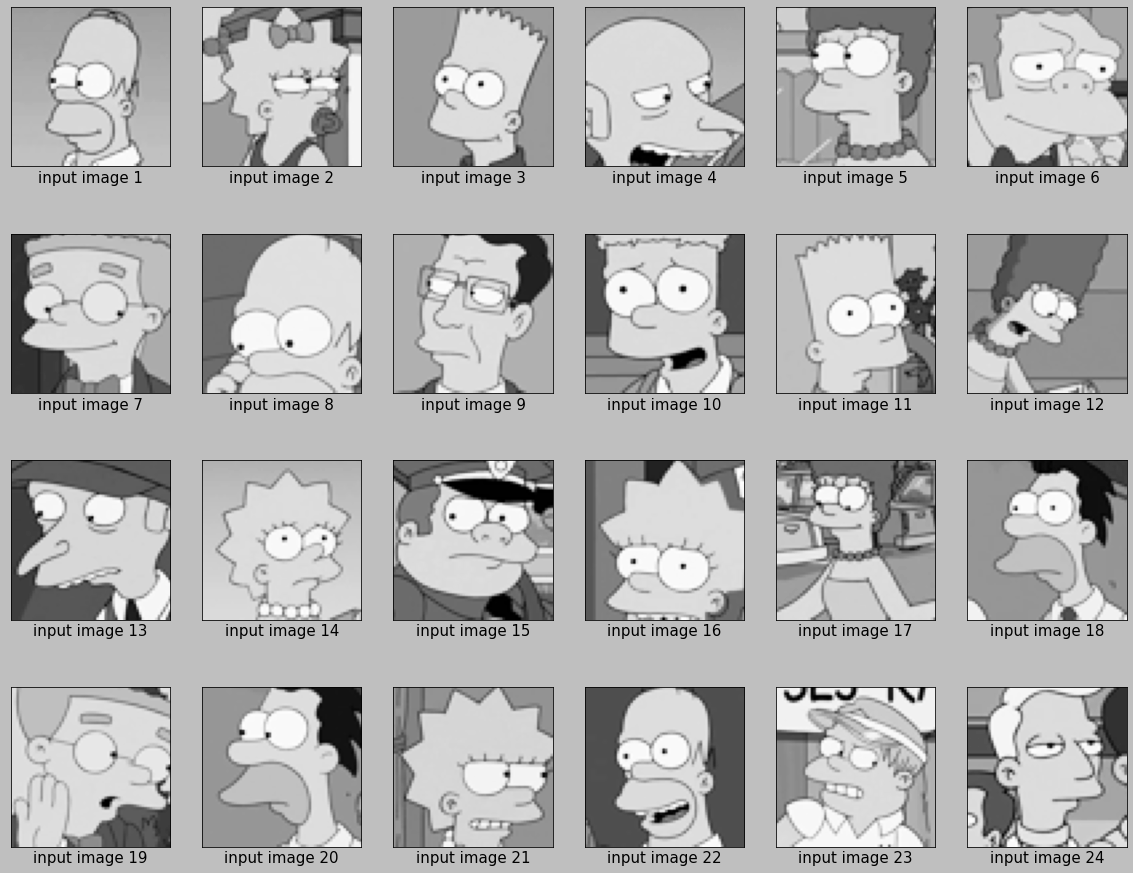

In [653]:
# Select patterns to memorise
patterns = np.array([load_simpson_grey(n) for n in [13, 20, 152, 201, 505, 812, 396, 548, 416, 150, 899, 136, 
                                               494, 445, 639, 459, 952, 973, 918, 977, 108, 979, 607, 532]])

# Plot patterns
fig=plt.figure(figsize=(20, 16))
columns = 6
rows = 4
ax = []
for i in range(1, columns*rows +1):
    ax.append(fig.add_subplot(rows, columns, i))
    plot_img(patterns[i-1])
    ax[i-1].set_xticks([])
    ax[i-1].set_yticks([])
    ax[i-1].set_xlabel("input image {}".format(i))

# fig.subplots_adjust(wspace=0.2)
plt.savefig("24_simpsons_cntns.png", dpi=150)
plt.show()

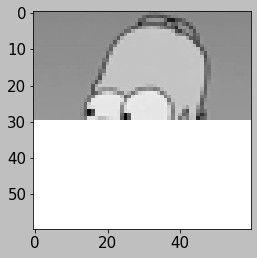

In [675]:
# test Hopfield net
X = patterns.copy().T.reshape((3600,24))
X = np.multiply(X, 1/np.linalg.norm(X, axis=0)).copy()
X = X/np.max(X)
ξ = X[:,0].copy()
ξ[1800:]=0
plt.imshow(ξ.reshape((60,60)), cmap="Greys")
save_img(ξ.reshape((60,60)), "cnts_homer_mask.png")

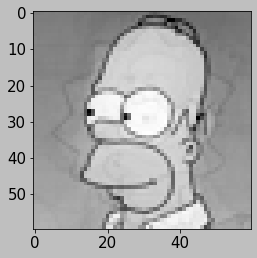

In [676]:
# Retrieve pattern
β = 0.14
H = Hopfield3(X,β)
out = H.simulate(ξ).reshape((60,60))
plt.imshow(out, cmap="Greys")
save_img(out, "cnts_homer.png")

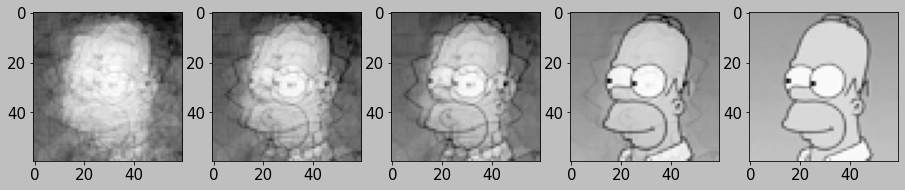

In [681]:
fig, ax = plt.subplots(1,5)
fig.set_size_inches(15.5, 3.5)
Bs = [0.05, 0.1, 0.12, 0.14, 0.18]
for i in range(5):
    b = Bs[i]
    H = Hopfield3(X,b)
    ξ = X[:,0].copy()
    ξ[1800:]=0
    ax[i].imshow(H.simulate(ξ).reshape((60,60)), cmap="Greys")
plt.savefig("homer_beta_fade.png", dpi=150)

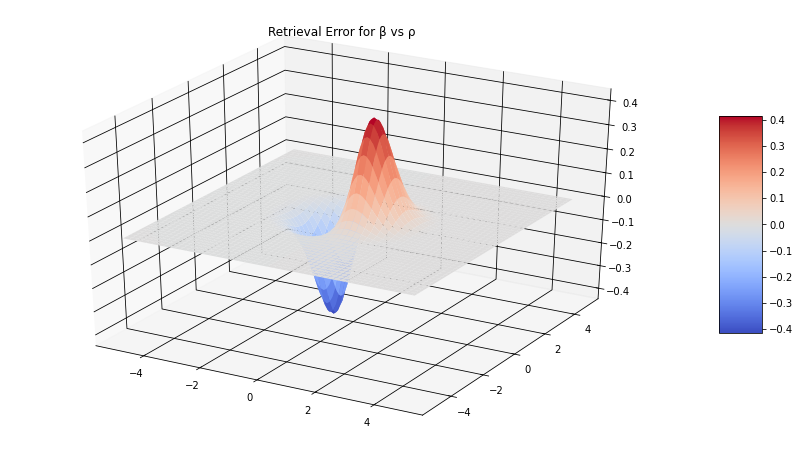

In [720]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
# if using a Jupyter notebook, include:
%matplotlib inline

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111, projection='3d')


x = np.arange(-5,5,0.1)
y = np.arange(-5,5,0.1)
X,Y = np.meshgrid(x,y)
Z = X*np.exp(-X**2 - Y**2)


ax1.set_title('Retrieval Error for β vs ρ')
surf1 = ax1.plot_surface(X, Y, Z, cmap="coolwarm")
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)


plt.show()